# TO-DOs
+ Load GloVe (L)
+ Run GloVe (C)
+ Add FastText (C)
+ Add LSA (L)
+ Prettify all plots (L)
+ Add hyperparams set-up to a Google Doc (C)

In [1]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

/cluster/apps/nss/gcc-6.3.0/python/3.7.4/x86_64/bin/python3.7
3.7.4 (default, Oct 16 2019, 13:45:57) 
[GCC 6.3.0]
sys.version_info(major=3, minor=7, micro=4, releaselevel='final', serial=0)


In [6]:
!pip install glove-python-binary

  Using cached https://files.pythonhosted.org/packages/cc/11/d8510a80110f736822856db566341dd2e1e7c3af536f77e409a6c09e0c22/glove_python_binary-0.2.0-cp37-cp37m-manylinux1_x86_64.whl


In [20]:
# Install necessary packages
# !pip install gdown
# !pip install --upgrade gensim

In [21]:
# Restart RUNTIME after installing packages!

In [3]:
import pandas as pd
import numpy as np
import gdown
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import ast
import pickle
from numpy.random import default_rng
import itertools

In [7]:
from gensim.models import Word2Vec
from glove import Glove, Corpus
from gensim.models.fasttext import FastText

import sys
sys.path.append('../pymodules')

In [8]:
# run this if interested in the Additional section
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', 118)
# pd.set_option('display.max_colwidth', 1000)
# pd.set_option('display.width', 10000)

In [9]:
# define paths and seed
SEED = 45
data_path = "./"

In [5]:
# define dictionary with paths to data in Google Drive
data_url_dict = {"10K_vocab_2019_min25": ("https://drive.google.com/uc?id=1va-ob3C7UD0pYV4Z6WEhL2WMP7ynQJCH", "csv"),
                "10K_dtmatrix_2019_min25": ("https://drive.google.com/uc?id=1c-lNSgaj3tKjnkpn_12ddCL3OP6IsXLT", "txt"),
                "10K_raw_text_2019_min25": ("https://drive.google.com/uc?id=1T97btZK10417MNXGlx_ASFY0mzqpNtu9", "csv"), 
                "tic_cik_crosswalk": ("https://drive.google.com/uc?id=1YsbeWapKf_hvfP3qMo9-Xj-PFuH5R96o", "csv")}

In [ ]:
# download each file in the dictionary (it takes a while)
for file_name, attributes in data_url_dict.items():
    url = attributes[0]
    extension = attributes[1]
    gdown.download(url, f"{file_name}.{extension}", quiet=False) 

# 1. Load data

This tutorial uses text data from the **10-K reports** filed by most publicly-traded firms in the U.S. in 2019. 10-K reports are a very rich source of data since firms include information regarding their organizational structure, financial performance and risk factors. We will use a version of the data where the risk factors section of each report has been splitted into sentences and each sentence has been assigned an ID that combines the firm identifier (i.e. **CIK**) and a sentence number. The data we use has a total of 1,077,416 sentences for 2,500 firms.

More on the 10-K reports [here](https://www.investor.gov/introduction-investing/getting-started/researching-investments/how-read-10-k).

In [ ]:
raw_data = pd.read_csv(data_path + '10K_raw_text_2019_min25.csv', index_col='Unnamed: 0')

dt_mat = pd.read_csv(data_path + '10K_dtmatrix_2019_min25.txt', index_col='Unnamed: 0')
dt_vals = dt_mat.values

vocab_df = pd.read_csv(data_path + '10K_vocab_2019_min25.csv', index_col='Unnamed: 0')

vocab = vocab_df.to_dict()['0']

In [11]:
tics = pd.read_csv('../../tic_cik_crosswalk.csv') #3196
raw_data.cik.isin(tics.cik).sum()

3196

In [82]:
# alternative ticker datasets (even fewer matches)

# tickers = pd.read_csv('../../cik_ticker.csv', sep='|') #2684
# tickers2 = pd.read_csv('../../ticker_2.txt', sep='\t', header=None, names=['ticker', 'cik']) #3183

In [12]:
df = raw_data.merge(tics, on='cik', how='left').copy()

# Estimate models

In [13]:
V = 700

In [14]:
%%time
# 3min
tokens_min25 = [ast.literal_eval(x) for x in df.tokens_25]

CPU times: user 2min 17s, sys: 2.21 s, total: 2min 19s
Wall time: 2min 20s


In [24]:
tokens = [ast.literal_eval(x) for x in df.tokens]

In [25]:
unique_tokens = np.array(list(set([t for to in tokens_min25 for t in to])))

# %%
w_pairs = []
w_pairs_lists = []
for i in range(10000):
    rng = default_rng(i)
    sel = rng.choice(unique_tokens, size=2, replace=False)
    if list(sel) not in w_pairs_lists:
        w_pairs.append(sel)
        w_pairs_lists.append(list(sel))
    else:
        print('double!', sel)

In [28]:
%%time
# %%
# SKIP_GRAM
# 2h 15min
# sg = 1 skipgram, sg=0 CBOW
w2v_sg = Word2Vec(sentences=tokens_min25, 
                 size=V, min_count=1, sg=1, 
                 window=7, negative=20, seed=SEED)

CPU times: user 2h 4min 36s, sys: 48.3 s, total: 2h 5min 24s
Wall time: 42min 11s


In [29]:
# %%
with open(data_path + f'w2v_sg_min25.sav' , 'wb') as f:
    pickle.dump((w2v_sg), f)

In [30]:
# %%
with open(data_path + f'w2v_sg_min25.sav', 'rb') as fr:
    w2v_sg = pickle.load(fr)

In [32]:
%%time
# %%
# CBOW
# 18 min
# sg = 1 skipgram, sg=0 CBOW
w2v_cb = Word2Vec(sentences=tokens_min25, 
                 size=V, min_count=1, sg=0, 
                 window=7, negative=20, seed=SEED)

CPU times: user 19min 5s, sys: 11.3 s, total: 19min 17s
Wall time: 6min 35s


In [33]:
# %%
with open(data_path + f'w2v_cb_min25.sav' , 'wb') as f:
    pickle.dump((w2v_cb), f)

In [34]:
# %%
with open(data_path + f'w2v_cb_min25.sav', 'rb') as fr:
    w2v_cb = pickle.load(fr)

In [21]:
%%time
#24 min
# %%
corpus_model = Corpus()
corpus_model.fit(tokens_min25, window=7)
# %%
glove = Glove(no_components=V, learning_rate=0.05)
glove.fit(corpus_model.matrix, verbose=True)
# %%
glove.add_dictionary(corpus_model.dictionary)

Performing 5 training epochs with 2 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
CPU times: user 24min 29s, sys: 17 s, total: 24min 46s
Wall time: 13min 1s


In [22]:
# %%
with open(data_path + f'glove_min25.sav' , 'wb') as f:
    pickle.dump((glove), f)

In [23]:
# %%
with open(data_path + f'glove_min25.sav', 'rb') as fr:
    glove = pickle.load(fr)
#%%

In [18]:
%%time
#10 min
fasttext = FastText(tokens_min25,
                      size=V,
                      window=7,
                      min_count=1,
                      sample=20,
                      workers = 4,
                      sg=1)

CPU times: user 37min 59s, sys: 33.9 s, total: 38min 32s
Wall time: 10min 38s


In [20]:
#%%
fasttext.save('fasttext_min25.sav')
fasttext = FastText.load('fasttext_min25.sav')

# Cosine similarity comparison

In [35]:
def similarity_query(w1, w2, model):
    id1 = model.dictionary[w1]
    id2 = model.dictionary[w2]
    vec1 = model.word_vectors[id1].reshape(1, -1)
    vec2 = model.word_vectors[id2].reshape(1, -1)

    dst = cosine_similarity(vec1,vec2)
    dst = dst[0][0]

    return dst

In [36]:
sims_w2v_sg = np.array([w2v_sg.wv.similarity(w1, w2) for w1,w2 in w_pairs])
sims_w2v_cb = np.array([w2v_cb.wv.similarity(w1, w2) for w1,w2 in w_pairs])
sims_glove = np.array([similarity_query(w1, w2, glove) for w1,w2 in w_pairs])
sims_fastext = np.array([fasttext.wv.similarity(w1, w2) for w1,w2 in w_pairs])

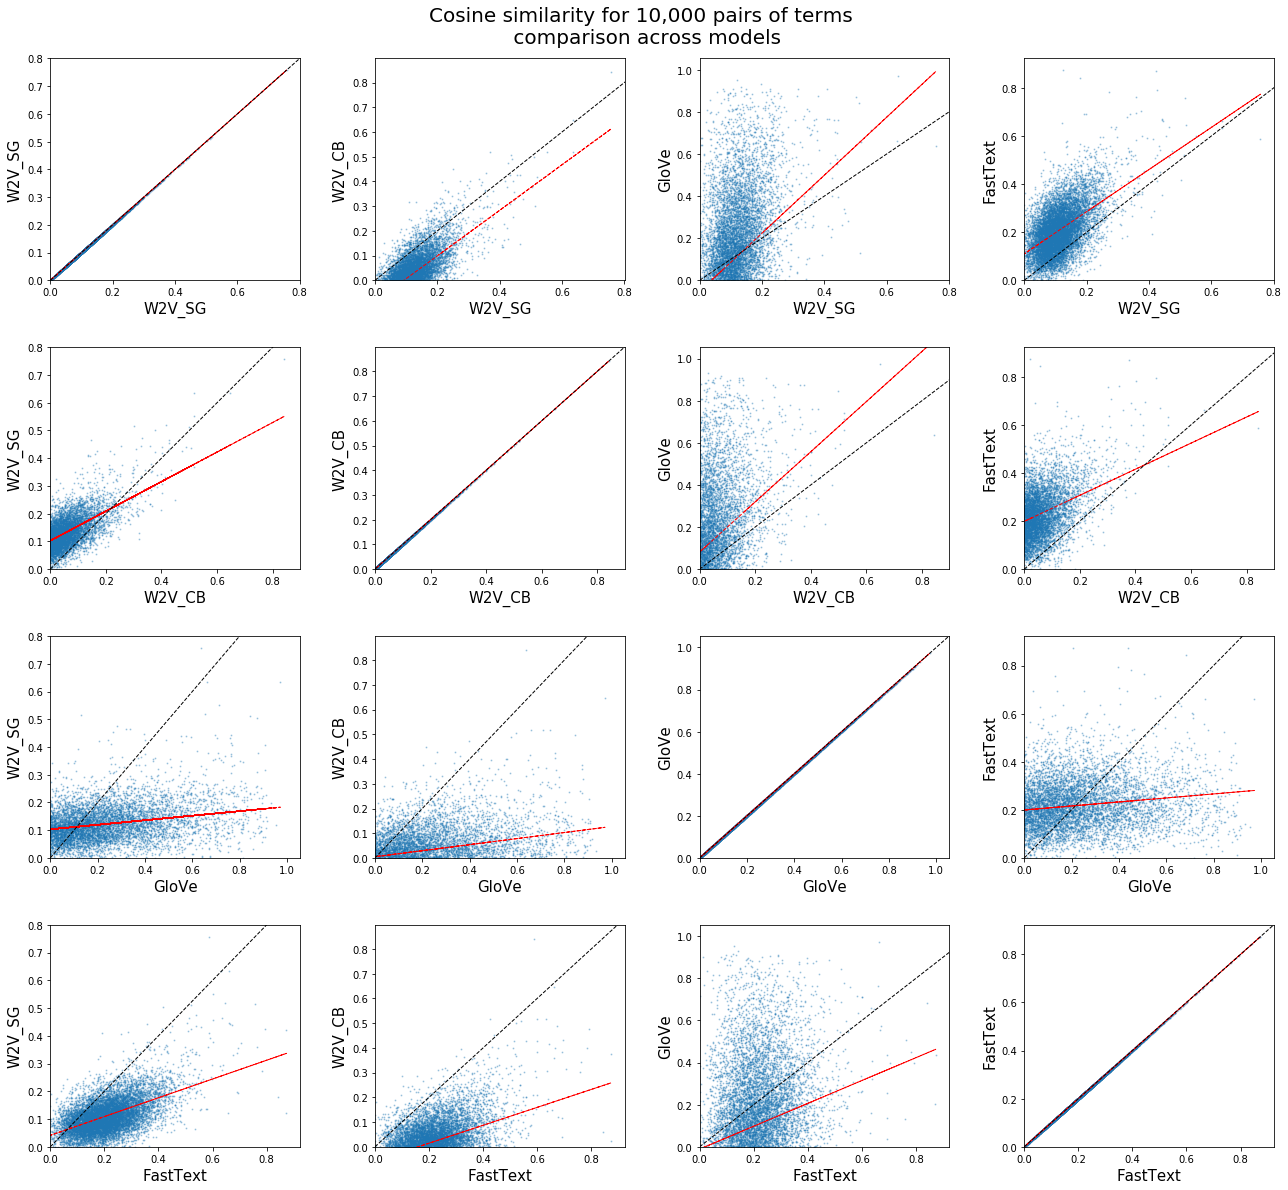

In [37]:
# %%
sample_range = np.linspace(0, len(sims_w2v_sg)-1,10000).astype(int)
#%%
fig, ax = plt.subplots(4,4, figsize=(18,18))
fig.suptitle('Cosine similarity for 10,000 pairs of terms \n comparison across models',
size=20)
sims_all = [sims_w2v_sg, sims_w2v_cb, sims_glove, sims_fastext]
names = ['W2V_SG', 'W2V_CB', 'GloVe', 'FastText']

for i in np.arange(4):
    for j in np.arange(4):
        x = sims_all[i][sample_range]
        y = sims_all[j][sample_range]

        ax[i][j].scatter(x,y, alpha=0.3, s=1)
        ax[i][j].set_ylim(bottom=0)
        ax[i][j].set_xlim(left=0)
        ax[i][j].set_xlabel(names[i], size=15)
        ax[i][j].set_ylabel(names[j], size=15)

        m, b = np.polyfit(x, y, 1)
        ax[i][j].plot(x, m*x + b, color='red', linewidth=1, linestyle='dashed')

        ax[i][j].plot(np.arange(0,3.05,0.05), np.arange(0,3.05,0.05), color='black', linewidth=1, linestyle='dashed')


plt.tight_layout()
plt.subplots_adjust(left=None, bottom=0.1, right=None, top=0.94, wspace=0.3, hspace=0.3)

plt.show()

# KNN Analysis

In [41]:
# %%
sel_terms = ['growth',  'stockholder', 'product', 'oil_price_np', 'weak',
'bankruptcy', 'advertising']
# %%
n_terms_sg = len(w2v_sg.wv)
n_terms_cb = len(w2v_cb.wv)
#n_terms_glove = glove.word_vectors.shape[0]
# %%
for term in sel_terms:
    all_sims_sg = list(list(zip(*w2v_sg.wv.most_similar([w2v_sg.wv[term]], topn=n_terms_sg)))[0])
    top_10_sg = pd.Series(list(all_sims_sg[1:10]))
    last_10_sg = pd.Series(list(reversed(all_sims_sg[-10:])))

    all_sims_cb = list(list(zip(*w2v_cb.wv.most_similar([w2v_cb.wv[term]], topn=n_terms_cb)))[0])
    top_10_cb = pd.Series(list(all_sims_cb[1:10]))
    last_10_cb = pd.Series(list(reversed(all_sims_cb[-10:]))) 

#     all_sims_glove = list(list(zip(*glove.most_similar(term, number=n_terms_glove)))[0])
#     top_10_glove = pd.Series(list(all_sims_glove[:10]))
#     last_10_glove = pd.Series(list(reversed(all_sims_glove[-10:])))

#     print(f'TARGET TERM: {term}')
#     sims_df = pd.concat([top_10_sg, top_10_cb, top_10_glove, last_10_sg, last_10_cb, last_10_glove], axis=1)
#     header = pd.MultiIndex.from_product([['---------------------------------- Top 10 NN ----------------------------------',
#     '---------------------------------- Bottom 10 NN ----------------------------------'],
#                                     ['w2v SG','w2v CB','GloVe']])

    print(f'TARGET TERM: {term}')
    sims_df = pd.concat([top_10_sg, top_10_cb, last_10_sg, last_10_cb], axis=1)
    header = pd.MultiIndex.from_product([['---------------------------------- Top 10 NN ----------------------------------',
    '---------------------------------- Bottom 10 NN ----------------------------------'],
                                    ['w2v SG','w2v CB']])
    sims_df.columns = header
    display(sims_df)

# %%

TARGET TERM: growth


---------------------------------- Top 10 NN ----------------------------------  \
                                                                           w2v SG   
0                                   future_growth_np                                
1                                    rapid_growth_np                                
2                                               grow                                
3                                     such_growth_np                                
4                                 continue_growth_np                                
5                              significant_growth_np                                
6                                 growth_strategy_np                                
7                                potential_growth_np                                
8                               anticipate_growth_np                                
9                                                NaN                                

                         \
                 w2v CB   
0      future_growth_np   
1     revenue_growth_np   
2                  grow   
3  anticipate_growth_np   
4    ability_to_grow_np   
5    growth_strategy_np   
6    continue_growth_np   
7        such_growth_np   
8             expansion   
9                   NaN   

  ---------------------------------- Bottom 10 NN ----------------------------------  \
                                                                              w2v SG   
0                                      frank_wall_np                                   
1                                     person_life_np                                   
2                             imposition_of_taxis_np                                   
3                                            offeror                                   
4                                              fault                                   
5                                          allegedly                                   
6                                           original                                   
7                                        substantive                                   
8                                        declaratory                                   
9                                    business_day_np                                   

                    
            w2v CB  
0  level_income_np  
1         operated  
2          wherein  
3           listed  
4           oblige  
5          cleared  
6   schedule_k_ent  
7       guaranteed  
8         assignee  
9              bar

TARGET TERM: stockholder


---------------------------------- Top 10 NN ----------------------------------  \
                                                                           w2v SG   
0                                        shareholder                                
1                        inability_of_stockholder_np                                
2                                     securityholder                                
3                                such_stockholder_np                                
4                                   common_stock_ent                                
5                       shareholder_in_connection_np                                
6                         interest_of_stockholder_np                                
7                                 security_holder_np                                
8                              common_shareholder_np                                
9                                                NaN                                

                           \
                   w2v CB   
0             shareholder   
1      security_holder_np   
2   common_shareholder_np   
3   common_stockholder_np   
4    other_stockholder_np   
5  current_shareholder_np   
6  current_stockholder_np   
7                  holder   
8    common_unitholder_np   
9                     NaN   

  ---------------------------------- Bottom 10 NN ----------------------------------  \
                                                                              w2v SG   
0                                     underdeveloped                                   
1                                         regionally                                   
2                                              shape                                   
3                                        predominant                                   
4                                                bye                                   
5                                       segmentation                                   
6                               level_of_spending_np                                   
7                                             modern                                   
8                                   market_change_np                                   
9                                       geographical                                   

                      
              w2v CB  
0       intermittent  
1         functional  
2                gps  
3         disposable  
4  relate_product_np  
5            outdoor  
6           localize  
7           validate  
8            science  
9                lab

TARGET TERM: product


---------------------------------- Top 10 NN ----------------------------------  \
                                                                           w2v SG   
0                                    such_product_np                                
1                                   other_product_np                                
2                               product_candidate_np                                
3                                       such_drug_np                                
4                           acceptance_of_product_np                                
5                                            branded                                
6                                            cleared                                
7                                  future_product_np                                
8                                     new_product_np                                
9                                                NaN                                

                         \
                 w2v CB   
0       such_product_np   
1      other_product_np   
2     future_product_np   
3    certain_product_np   
4        new_product_np   
5  product_candidate_np   
6    sale_of_product_np   
7              solution   
8  potential_product_np   
9                   NaN   

  ---------------------------------- Bottom 10 NN ----------------------------------  \
                                                                              w2v SG   
0                                                158                                   
1                                                245                                   
2                                                155                                   
3                                                132                                   
4                                                264                                   
5                                                135                                   
6                                                114                                   
7                                                167                                   
8                                                214                                   
9                                                725                                   

                           
                   w2v CB  
0            unencumbered  
1                     mid  
2           collateralize  
3        related_party_np  
4               sponsored  
5       corporate_debt_np  
6     investment_trust_np  
7      other_financing_np  
8       free_treatment_np  
9  time_of_disposition_np

TARGET TERM: oil_price_np


---------------------------------- Top 10 NN ----------------------------------  \
                                                                           w2v SG   
0                               natural_gas_price_np                                
1                                 crude_oil_price_np                                
2                                       gas_price_np                                
3                                   price_for_oil_np                                
4                                    price_of_oil_np                                
5                                       ngl_price_np                                
6                                    level_of_oil_np                                
7  organization_of_petroleum_exporting_countries_ent                                
8                        west_texas_intermediate_ent                                
9                                                NaN                                

                         \
                 w2v CB   
0    crude_oil_price_np   
1       price_of_oil_np   
2          ngl_price_np   
3  natural_gas_price_np   
4      price_for_oil_np   
5    commodity_price_np   
6       level_of_oil_np   
7          gas_price_np   
8       energy_price_np   
9                   NaN   

  ---------------------------------- Bottom 10 NN ----------------------------------  \
                                                                              w2v SG   
0                                  general_ledger_np                                   
1                       extraordinary_transaction_np                                   
2                                           narrowly                                   
3                                      inadvertently                                   
4                                  transfer_agent_np                                   
5                                        duplication                                   
6                             financial_liability_np                                   
7                             other_communication_np                                   
8                       information_in_connection_np                                   
9                        information_with_respect_np                                   

                             
                     w2v CB  
0                    assist  
1   software_application_np  
2                 registrar  
3  due_diligence_process_np  
4         other_software_np  
5       software_product_np  
6       other_technology_np  
7                     patch  
8        banking_service_np  
9  complementary_product_np

TARGET TERM: weak


---------------------------------- Top 10 NN ----------------------------------  \
                                                                           w2v SG   
0                          high_unemployment_rate_np                                
1                         low_consumer_confidence_np                                
2                                           stagnate                                
3                                           weakened                                
4                                          weakening                                
5                                       recessionary                                
6                               high_unemployment_np                                
7                         high_unemployment_level_np                                
8                              economic_condition_np                                
9                                                NaN                                

                             \
                     w2v CB   
0              recessionary   
1                    worsen   
2                 weakening   
3                 worsening   
4  further_deterioration_np   
5                  weakened   
6               deteriorate   
7      high_unemployment_np   
8               contraction   
9                       NaN   

  ---------------------------------- Bottom 10 NN ----------------------------------  \
                                                                              w2v SG   
0                                       such_plan_np                                   
1                             standard_of_conduct_np                                   
2                               certain_condition_np                                   
3                                          formulate                                   
4                                            complie                                   
5                                               none                                   
6                                future_liability_np                                   
7                                      frank_wall_np                                   
8                                           satisfie                                   
9                                               fine                                   

                                     
                             w2v CB  
0                        prospectus  
1                           offeror  
2  therapeutic_product_candidate_np  
3         judgment_of_management_np  
4                            manner  
5                           propose  
6               remedial_measure_np  
7                public_offering_np  
8                         identifie  
9                              form

TARGET TERM: bankruptcy


---------------------------------- Top 10 NN ----------------------------------  \
                                                                           w2v SG   
0                                         insolvency                                
1                       applicable_bankruptcy_law_np                                
2                           bankruptcy_proceeding_np                                
3                      relevant_portfolio_company_np                                
4                             file_for_bankruptcy_np                                
5                                  bankruptcy_law_np                                
6                             event_of_bankruptcy_np                                
7                               bankruptcy_filing_np                                
8                             party_with_priority_np                                
9                                                NaN                                

                             \
                     w2v CB   
0  bankruptcy_proceeding_np   
1                insolvency   
2      bankruptcy_filing_np   
3    event_of_bankruptcy_np   
4    file_for_bankruptcy_np   
5     financial_distress_np   
6                    debtor   
7   financial_difficulty_np   
8                   default   
9                       NaN   

  ---------------------------------- Bottom 10 NN ----------------------------------  \
                                                                              w2v SG   
0                  international_expansion_effort_np                                   
1                   significant_management_effort_np                                   
2                                        scalability                                   
3                             level_of_investment_np                                   
4                      compliance_with_regulation_np                                   
5                                               mode                                   
6                              personnel_in_order_np                                   
7                                        complicated                                   
8                                          biodiesel                                   
9                                           invasive                                   

                          
                  w2v CB  
0                 insert  
1                library  
2                speaker  
3     product_feature_np  
4         open_source_np  
5         key_element_np  
6            educational  
7            scalability  
8  additional_product_np  
9     current_product_np

TARGET TERM: advertising


---------------------------------- Top 10 NN ----------------------------------  \
                                                                           w2v SG   
0                                          promotion                                
1                                         advertiser                                
2                             digital_advertising_np                                
3                                          advertise                                
4                                online_marketing_np                                
5                              online_advertising_np                                
6                         approval_clinical_datum_np                                
7                                        promotional                                
8                                      advertisement                                
9                                                NaN                                

                            \
                    w2v CB   
0   digital_advertising_np   
1  advertising_campaign_np   
2                advertise   
3    online_advertising_np   
4            advertisement   
5              promotional   
6   promotional_program_np   
7               advertiser   
8   advertising_revenue_np   
9                      NaN   

  ---------------------------------- Bottom 10 NN ----------------------------------  \
                                                                              w2v SG   
0                                 right_of_holder_np                                   
1                             other_debt_security_np                                   
2                                 equity_interest_np                                   
3                                      frank_wall_np                                   
4                            current_market_price_np                                   
5                                            5000000                                   
6                             other_work_stoppage_np                                   
7                                           blackout                                   
8                           adverse_weather_event_np                                   
9                               purchase_contract_np                                   

                                   
                           w2v CB  
0         environmental_hazard_np  
1                 other_hazard_np  
2                 loss_of_life_np  
3                   above_risk_np  
4         temporary_impairment_np  
5       significant_disruption_np  
6  connection_with_acquisition_np  
7                severe_damage_np  
8          integration_process_np  
9               unknown_factor_np

# Ranking comparison

In [38]:
# %%
def similarity_query(w1, w2, model):
    id1 = model.dictionary[w1]
    id2 = model.dictionary[w2]
    vec1 = model.word_vectors[id1].reshape(1, -1)
    vec2 = model.word_vectors[id2].reshape(1, -1)

    dst = cosine_similarity(vec1,vec2)
    dst = dst[0][0]

    return dst

In [39]:
#%%
# extract 10,000 unique triplets of firms
n_samples = 10000
#%%
models = [w2v_sg, w2v_cb, glove, fasttext]
model_names = ['sg', 'cb', 'glove', 'fasttext']
rankings = {'sg':[], 'cb':[], 'glove':[], 'fasttext': []}

for i in range(n_samples):
    if i%1000==0:
        print(i)
    rng = default_rng(i)
    sel = rng.choice(unique_tokens, size=3, replace=False)
    for m_ix, model in enumerate(models):
        if model_names[m_ix]=='glove':
            sim1 = similarity_query(sel[0], sel[1], model=model)
            sim2 = similarity_query(sel[0], sel[2], model=model)
        else:
            sim1 = model.wv.similarity(sel[0], sel[1])
            sim2 = model.wv.similarity(sel[0], sel[2])
        rankings[model_names[m_ix]].append(1 if sim1>sim2 else 0)

# %%
rankings = {k:np.array(v) for k,v in rankings.items()}

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [40]:
# %%
fractions = {f'{a}_{b}': (rankings[a]==rankings[b]).sum()/n_samples
for a,b in list(itertools.combinations(model_names, 2))}

fractions

{'sg_cb': 0.7477,
 'sg_glove': 0.6066,
 'sg_fasttext': 0.6731,
 'cb_glove': 0.6391,
 'cb_fasttext': 0.6368,
 'glove_fasttext': 0.5663}

In [41]:
fraction_mat = []
for n_ix, n in enumerate(model_names):
    row = []
    for m_ix, m in enumerate(model_names):
        frac = (rankings[n]==rankings[m]).sum()/n_samples
        row.append(frac)
    fraction_mat.append(np.array(row)) 
fraction_mat = np.array(fraction_mat)

In [42]:
fraction_df = pd.DataFrame(fraction_mat, index=names)
fraction_df.columns = names

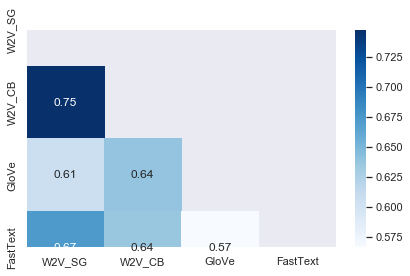

In [59]:
fig = plt.Figure(figsize=(19,19))
sns.set(font_scale=1)
sns.heatmap(fraction_df, cmap='Blues', annot=True, mask = np.triu(fraction_mat))
plt.tight_layout()
plt.show()